# Houston Housing Value Prediction

The goal of this project is to estimate what the housing prices in different neighborhoods in Houston, Texas will be in the next six months.

The data for this project was downloaded from Zillow and uses their Housing Value Index (ZHVI). To read more on it, visit this website: https://www.zillow.com/research/data/. The ZHVI is the response variable and the Sales Count (demand) and Listing Inventory (supply) are the predictor variables along with the time series.

This project uses multiple linear regression to predict the ZHVI for November 2025 - June 2026.

## EDA and Preprocessing

In this section, the data will be loaded from three different files and combined into one dataframe. It will then be cleaned.

In [551]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

First, we'll clean our response variable, ZHVI, data.

In [521]:
# load data into dataframes

# load ZVHI data (response)
zhvi_df = pd.read_csv('ZHVI_Neighborhood_2000-2025.csv')

zhvi_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/2000,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
0,112345,0,Maryvale,neighborhood,AZ,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,7.738213e+04,...,3.519842e+05,3.512025e+05,3.503019e+05,3.487601e+05,3.464663e+05,3.440807e+05,3.417890e+05,3.395757e+05,3.375961e+05,3.358661e+05
1,192689,1,Paradise,neighborhood,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,1.361210e+05,...,4.064689e+05,4.080133e+05,4.093978e+05,4.098772e+05,4.091924e+05,4.080713e+05,4.070375e+05,4.059242e+05,4.044068e+05,4.025022e+05
2,270958,2,Upper West Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,8.803485e+05,...,2.715419e+06,2.715568e+06,2.715509e+06,2.716631e+06,2.723017e+06,2.725498e+06,2.717370e+06,2.704765e+06,2.694029e+06,2.686323e+06
3,270957,3,Upper East Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,1.541823e+06,...,2.734325e+06,2.740456e+06,2.746430e+06,2.746224e+06,2.744627e+06,2.737929e+06,2.724631e+06,2.711535e+06,2.709680e+06,2.719538e+06
4,118208,4,South Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,1.346851e+05,...,7.121462e+05,7.148230e+05,7.130346e+05,7.077595e+05,6.984482e+05,6.896761e+05,6.817595e+05,6.763374e+05,6.752062e+05,6.767582e+05


In [522]:
# get rid of rows that are not Neighborhoods in Houston or Bellaire

# filter by state
zhvi_df = zhvi_df[zhvi_df['State'] == 'TX']
# filter by city
zhvi_df = zhvi_df[zhvi_df['City'] == 'Houston']

# store neighborhoods willing to keep
neighborhoods = ['Fourth Ward', 'Greater Eastwood', 'Greater Heights', 'Lazy Brook - Timbergrove', 
                 'Medical Center Area', 'Memorial', 'Midtown', 'Neartown - Montrose', 'Second Ward', 'University Place', 
                 'Washington Avenue Coalition - Memorial Park', 'West University Place']

# filter by neighborhood
zhvi_df = zhvi_df[zhvi_df['RegionName'].isin(neighborhoods)]


In [523]:
# get rid of unnecessary columns (only need data from January 2018 - August 2025)

# establish list of wanted years
years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']

# initialize column list for removal
cols_to_drop = ['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'] # already added columns that are no longer needed after removing unnecessary rows

# add monthly columns that are not needed (only inspecting data from 2018 to present)
for col in zhvi_df.columns: # monthly columns start at index 9
    if col[-4:-2] == '20': # if column is for a month
        if col[-4:] not in years:
            cols_to_drop.append(col)
        if col[-4:] == '2018' and col[-9] in ['1', '2']: # drop column if for data in 2018 prior to March
            cols_to_drop.append(col)

# drop unnecessary columns
zhvi_df.drop(columns = cols_to_drop, inplace = True)

zhvi_df.head()

,RegionName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,1/31/2019,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
187,Memorial,351179.992033,348162.719966,346644.101932,345664.364897,344649.016722,342895.840112,340590.376787,338911.142746,336299.160794,...,407871.252055,408197.316587,408724.525226,409760.920112,409930.622090,409828.180034,409166.139861,4.086662e+05,4.089987e+05,410163.887570
200,Greater Heights,474801.167724,476077.398700,478418.275000,480301.636181,481513.922550,482405.182441,483000.559927,483854.432777,486718.178833,...,614646.821502,614648.895421,614704.870267,615046.685832,614822.864200,614138.390173,612236.332819,6.093760e+05,6.060337e+05,603023.131866
304,Washington Avenue Coalition - Memorial Park,441045.986927,441378.904509,442612.097473,443271.593483,443261.498100,442623.937898,441465.659689,440415.359133,440315.425063,...,533035.068400,530901.782282,529417.851744,528767.016900,527575.206027,525417.180595,522344.910577,5.186046e+05,5.148284e+05,511587.341085
351,Neartown - Montrose,568638.216662,570287.051327,573088.026700,575788.977111,577365.429680,577695.668249,576600.766132,575152.644459,573056.653638,...,675019.429521,672975.226646,671555.683311,671578.118460,672246.628909,672440.526595,671193.598881,6.684368e+05,6.643009e+05,660692.930883
747,University Place,763983.572381,765319.971506,768585.251047,772282.312721,774450.233906,776339.717400,777513.012128,779310.908338,780080.894900,...,981803.940100,984369.147617,985172.557200,987440.632522,989620.424587,994032.267242,998840.592300,1.001855e+06,1.001562e+06,998471.564481


In [524]:
zhvi_df.dtypes

RegionName     object
3/31/2018     float64
4/30/2018     float64
5/31/2018     float64
6/30/2018     float64
               ...   
4/30/2025     float64
5/31/2025     float64
6/30/2025     float64
7/31/2025     float64
8/31/2025     float64
Length: 89, dtype: object

Next, we'll clean our Listing Inventory (supply) data.

In [525]:
# load data into dataframe
supply_df = pd.read_csv('Zillow_Listing_Inventory_2018-2025.csv')

# inspect
supply_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
0,102001,0,United States,country,NaN,1421529.0,1500195.0,1592417.0,1660618.0,1709146.0,...,1171775,1113415,1063139,1044334,1098988,1168973,1264336,1331581,1375240,1381177
1,394913,1,"New York, NY",msa,NY,73707.0,80345.0,85864.0,90067.0,91881.0,...,42518,39331,36032,34735,36924,40216,44488,47428,48809,47858
2,753899,2,"Los Angeles, CA",msa,CA,21998.0,23784.0,25605.0,27109.0,28811.0,...,21015,19333,18159,18197,19935,21649,23676,25139,26385,26661
3,394463,3,"Chicago, IL",msa,IL,38581.0,42253.0,45757.0,47492.0,48984.0,...,23889,21756,19478,18369,19056,20217,21911,23223,24102,24181
4,394514,4,"Dallas, TX",msa,TX,24042.0,25876.0,28224.0,30490.0,32408.0,...,31420,30014,28652,28138,29598,31893,35005,37477,38936,39024


In [526]:
# remove unnecessary rows

# filter by state
supply_df = supply_df[supply_df['StateName'] == 'TX']

# filter by city
supply_df = supply_df[supply_df['RegionName'] == 'Houston, TX']

# remove unnecessary columns
supply_df.drop(columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], inplace = True)

In [527]:
supply_df.dtypes

3/31/2018    float64
4/30/2018    float64
5/31/2018    float64
6/30/2018    float64
7/31/2018    float64
              ...   
4/30/2025      int64
5/31/2025      int64
6/30/2025      int64
7/31/2025      int64
8/31/2025      int64
Length: 90, dtype: object

In [528]:
# update all data types to be integers (looking at number of listings, which can only be a positive integer)
for col in supply_df.columns:
    supply_df[col] = supply_df[col].astype(int)

supply_df.dtypes

3/31/2018    int32
4/30/2018    int32
5/31/2018    int32
6/30/2018    int32
7/31/2018    int32
             ...  
4/30/2025    int32
5/31/2025    int32
6/30/2025    int32
7/31/2025    int32
8/31/2025    int32
Length: 90, dtype: object

In [529]:
supply_df

,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
5,25618,27360,29634,31129,32397,32911,32423,31475,30059,28517,...,28793,28035,27402,27517,29150,31312,33863,35665,37107,37570


Finally, we'll inspect and clean our Sales Count (demand) data.

In [530]:
# load data
demand_df = pd.read_csv('Number_of_Sales_2008-2025.csv')

demand_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
0,102001,0,United States,country,NaN,203575,235664,261534,288423,301614,...,274172,283345,228852,235767,289559,324220,350804,357806,353185,345094
1,394913,1,"New York, NY",msa,NY,8563,9079,10073,10484,11372,...,11318,12806,11141,9326,10831,11440,12373,13493,14457,14246
2,753899,2,"Los Angeles, CA",msa,CA,4133,5052,6084,6870,7215,...,5712,6000,4605,5274,6234,7012,6685,6589,6934,6476
3,394463,3,"Chicago, IL",msa,IL,5606,6959,7320,7982,8814,...,7395,7335,5953,5927,7441,8654,9479,10343,10290,9176
4,394514,4,"Dallas, TX",msa,TX,4984,5692,6110,6821,6793,...,5237,5489,4288,5051,6253,6715,7223,7068,7121,6609


In [531]:
demand_df.dtypes

RegionID       int64
SizeRank       int64
RegionName    object
RegionType    object
StateName     object
               ...  
4/30/2025      int64
5/31/2025      int64
6/30/2025      int64
7/31/2025      int64
8/31/2025      int64
Length: 216, dtype: object

In [532]:
# remove unnecessary rows

# filter by state
demand_df = demand_df[demand_df['StateName'] == 'TX']

# filter by city
demand_df = demand_df[demand_df['RegionName'] == 'Houston, TX']

# store columns to drop
cols_to_drop = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
# add monthly columns that are not needed (only inspecting data from March 2018 to present)
for col in demand_df.columns: # monthly columns start at index 9
    if col[-4:-2] == '20': # if column is for a month
        if col[-4:] not in years:
            cols_to_drop.append(col)
        if col[-4:] == '2018' and col[-9] in ['1', '2']: # drop column if for data in 2018 prior to March
            cols_to_drop.append(col)

# remove unnecessary columns
demand_df.drop(columns = cols_to_drop, inplace = True)

In [533]:
demand_df.head()

,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,1/31/2019,2/28/2019,...,11/30/2024,12/31/2024,1/31/2025,2/28/2025,3/31/2025,4/30/2025,5/31/2025,6/30/2025,7/31/2025,8/31/2025
5,6693,6940,8053,8431,7836,8034,6253,6379,3976,5018,...,4404,4847,3780,4140,5195,5881,6544,6316,6216,5788


It looks like we have 2 less months represented in our demand data than our supply data. Let's figure out which months those are and if they are included in our ZVHI data.

In [534]:
# get column names into sets for easy comparison
supply_months = set(supply_df.columns)
demand_months = set(demand_df.columns)

# compare supply and demand
missing_months = supply_months.symmetric_difference(demand_months)

missing_months

{'11/30/2018', '12/31/2018'}

In [535]:
# see if ZHVI months are represented in supply and demand

# restrict ZHVI columns to month columns
zhvi_months = set(zhvi_df.columns[1:]) # first column is region name (neighborhood)

# compare with supply and demand
supply_diff = zhvi_months.symmetric_difference(supply_months)
demand_diff = zhvi_months.symmetric_difference(demand_months)

print(supply_diff)
print(demand_diff)

{'12/31/2018', '11/30/2018'}
set()


Both ZHVI and demand are missing November and December of 2018. To fix this issue, we'll fill these holes with the column's average. (To be completed in next steps.)

Now that all our individual dataframes are clean and the same size, it's time to combine them into numpy arrays. We'll keep our predictor and response variables in separate arrays, but make sure they are formatted the same. For this, we want every month to be a row since they are individual observations. Then we'll get supply and demand as columns in one array and each neighborhood as a column in the other array.

In [536]:
# create predictor df

# transpose supply and demand
supply = supply_df.T.rename(columns = {supply_df.index[0]: 'supply'})
demand = demand_df.T.rename(columns = {demand_df.index[0]: 'demand'})

# concatenate into same df
supply_and_demand = supply.join(demand)

# make index (months) into a column
supply_and_demand = supply_and_demand.reset_index().rename(columns = {'index': 'month'})

# get month and year into date datatype
supply_and_demand['month'] = pd.to_datetime(supply_and_demand['month'], format = '%m/%d/%Y')

# fix demand -> found NA in July-October 2023 and dtype is float
# fill NA with average value
supply_and_demand.fillna(supply_and_demand.mean(), inplace = True)
supply_and_demand['demand'] = supply_and_demand['demand'].astype(int)

supply_and_demand

,month,supply,demand
0,2018-03-31,25618,6693
1,2018-04-30,27360,6940
2,2018-05-31,29634,8053
3,2018-06-30,31129,8431
4,2018-07-31,32397,7836
...,...,...,...
85,2025-04-30,31312,5881
86,2025-05-31,33863,6544
87,2025-06-30,35665,6316
88,2025-07-31,37107,6216


In [537]:
# update response df

# make neighborhoods the index
zhvi = zhvi_df.set_index('RegionName').rename_axis('month')

# transpose response
zhvi = zhvi.T

# create missing data -> new rows for November and December 2018 filled with average of October 2018 and January 2019
# grab data for missing values
november = zhvi.loc[['10/31/2018', '1/31/2019'], :].mean().to_frame().T.rename(index = {0: '11/30/2018'})
december = zhvi.loc[['10/31/2018', '1/31/2019'], :].mean().to_frame().T.rename(index = {0: '12/31/2018'})
# put them into a dataframe
missing_data_df = pd.concat([november, december])
# split existing dataframe
top = zhvi.loc[:'10/31/2018']
bottom = zhvi.loc['1/31/2019':] # 2019 onward
# put pieces together
zhvi = pd.concat([top, missing_data_df, bottom])

# make months into a column
zhvi = zhvi.reset_index().rename_axis('index').rename(columns = {'index': 'month'})
zhvi['month'] = pd.to_datetime(zhvi['month'], format = '%m/%d/%Y')

zhvi

month,month,Memorial,Greater Heights,Washington Avenue Coalition - Memorial Park,Neartown - Montrose,University Place,West University Place,Lazy Brook - Timbergrove,Midtown,Second Ward,Greater Eastwood,Fourth Ward,Medical Center Area
index,,,,,,,,,,,,,
0,2018-03-31,351179.992033,474801.167724,441045.986927,568638.216662,7.639836e+05,8.964721e+05,423850.803138,389668.879963,272045.954812,261848.592847,356976.982187,508413.993783
1,2018-04-30,348162.719966,476077.398700,441378.904509,570287.051327,7.653200e+05,8.988246e+05,424775.956517,389819.250106,274578.843124,263865.272197,357354.570450,508451.725161
2,2018-05-31,346644.101932,478418.275000,442612.097473,573088.026700,7.685853e+05,9.033901e+05,427506.205265,390291.993034,276019.386842,266336.150437,358331.162015,508404.029631
3,2018-06-30,345664.364897,480301.636181,443271.593483,575788.977111,7.722823e+05,9.088036e+05,429963.320325,390734.468821,277011.715219,268744.441248,359410.624424,508439.580747
4,2018-07-31,344649.016722,481513.922550,443261.498100,577365.429680,7.744502e+05,9.125793e+05,431467.004184,390551.566900,278390.313503,271222.000930,360335.800965,508543.273600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2025-04-30,409828.180034,614138.390173,525417.180595,672440.526595,9.940323e+05,1.292030e+06,561614.943292,448781.902040,365627.897256,353245.381988,426155.852955,560161.927140
86,2025-05-31,409166.139861,612236.332819,522344.910577,671193.598881,9.988406e+05,1.295443e+06,559029.709829,446833.624635,362439.774147,350907.612078,423222.002304,558346.470778
87,2025-06-30,408666.224850,609376.042076,518604.554737,668436.804686,1.001855e+06,1.295188e+06,556153.285522,444854.085658,358896.331863,348542.457244,419772.452930,556002.563796


### Visual Inspection of Data
All the data is clean and in the correct formats. Now, we'll make a few visualizations to see our data.

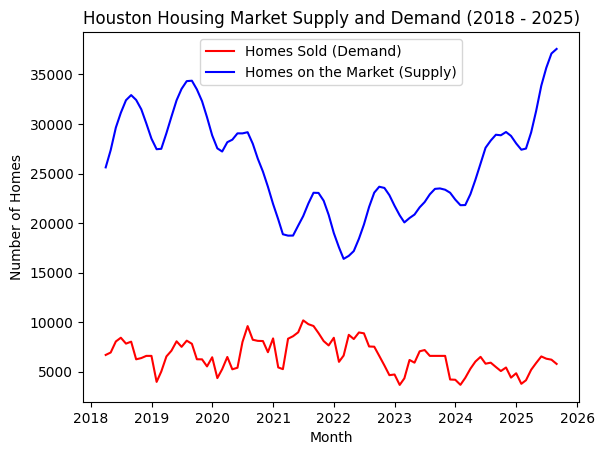

In [538]:
# plot supply and demand as separate lines and time on the x-axis

plt.figure()
plt.plot(supply_and_demand['month'], supply_and_demand['demand'], color = 'red', linestyle = '-', label = 'Homes Sold (Demand)')
plt.plot(supply_and_demand['month'], supply_and_demand['supply'], color = 'blue', linestyle = '-', label = 'Homes on the Market (Supply)')
plt.xlabel('Month')
plt.ylabel('Number of Homes')
plt.title('Houston Housing Market Supply and Demand (2018 - 2025)')
plt.legend()
plt.show()

From this plot, we see that demand tends to be relatively stable, while there are large dips and rises in supply. From this, we can predict that our supply data will have a larger coefficient in our linear regression model.

Interestingly, there also seems to be some peaks during summer and valleys during winter months. This occurs every year, despite where the market is at as a whole.

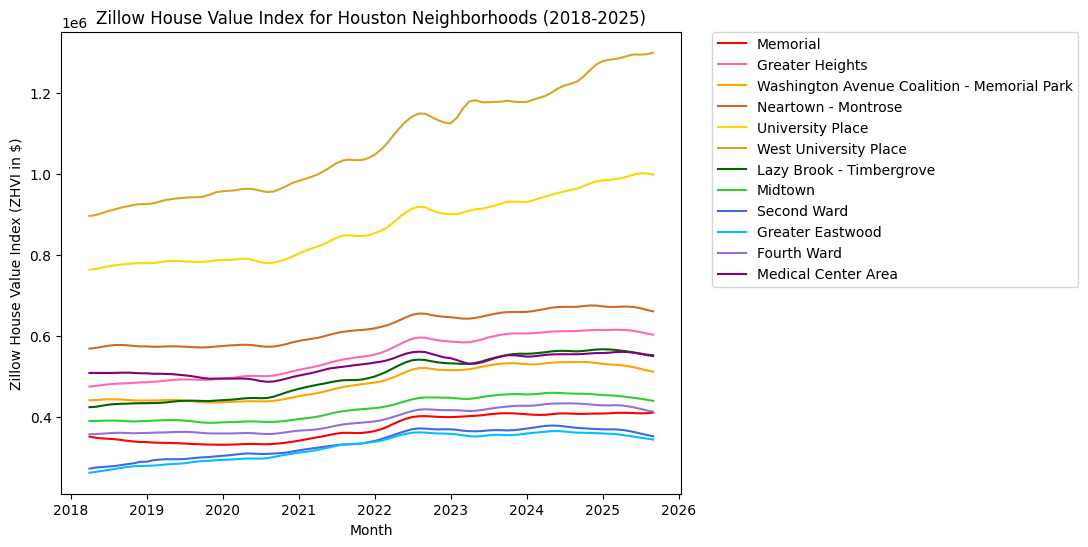

In [539]:
# plot each neighborhood as a function of time

plt.figure(figsize=(8, 6))
# make list of colors
colors = ['red', 'hotpink', 'orange', 'chocolate', 'gold', 'goldenrod', 'darkgreen', 'limegreen', 'royalblue', 'deepskyblue', 'mediumpurple', 'purple']
for ii, neighborhood in enumerate(zhvi.columns[1:]): # skip month column
    plt.plot(zhvi['month'], zhvi[neighborhood], color = colors[ii], linestyle = '-', label = neighborhood)
plt.xlabel('Month')
plt.ylabel('Zillow House Value Index (ZHVI in $)')
plt.title('Zillow House Value Index for Houston Neighborhoods (2018-2025)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

This graph shows that, while all the Neighborhood average home values have increase over the last few years, West University Place and University Place have increased almost exponentially. We'll expect the models for those two to look a bit different than the others. Otherwise, the lines move fairly parallel to each other with a few crossovers here and there. These changes show changes in the desirability of these neighborhoods.

Based on our graph of supply and demand, it looks like there is a possibility of a correlation between these predictor variables. Let's investigate this.

For the rest of the project, I will use Midtown as a representative neighborhood. I've chosen to use Midtown because it is around the middle of the pack.

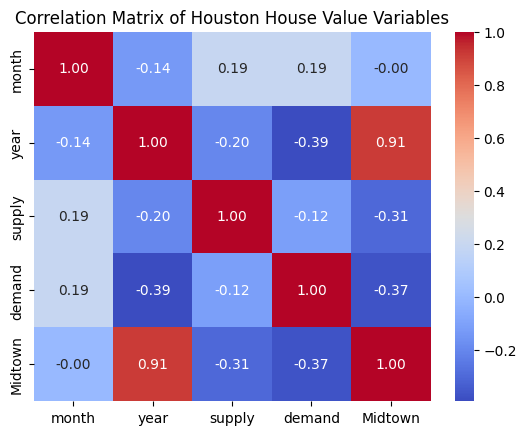

In [540]:
# get all data into one dataframe
midtown = zhvi[['Midtown', 'month']]
data = pd.merge(supply_and_demand, midtown, on = 'month', how = 'inner')

# split month and year into different columns to see if different effects
data['month/year'] = data['month']
data['month'] = data['month/year'].dt.month
data['year'] = data['month/year'].dt.year
data = data[['month', 'year', 'supply', 'demand', 'Midtown']]

# create correlation matrix
corr_matrix = data.corr()

# plot on heatmap
plt.figure()
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix of Houston House Value Variables')
plt.show()

This correlation matrix shows a large correlation between year and Midtown's ZHVI, but no relation between it and month. This is likely due to the cyclical nature not changing the overall market trends. We'll keep it for now while we investigate interactions between variables.

Supply and demand are both correlated with Midtown's ZHVI, which bodes well for using them as predictors in our model.

Year is also correlated with both supply and demand. Furthermore, supply and demand are slightly correlated, though not as much as each one is with year. This follows what we saw in our supply and demand graph, which hinted at long-term trends in the housing market and smaller tendencies for supply and demand to follow each other.

## Linear Regression

Our data has been correctly formatted and we've seen a little bit of information about them in our plots. In this section, we'll make a linear regression model for the Midtown neighborhood and attempt to make predictions for the ZHVI based on projected supply and demand for the next year.

### Interaction Terms

Based on our correlation matrix, we'll start with a model that includes interaction terms between each predictor. Once the statistical significance of the interaction term coefficients have been investigated, the terms will either stay or be removed. Next, we'll add polynomial terms for each predictor and investigate their statistical significance. Finally, we'll settle on a single model and use it to predict housing values in 2026.

In [541]:
# separate month and year in supply_and_demand (predictor df)
predictors = supply_and_demand.copy()
predictors['month/year'] = predictors['month']
predictors['month'] = predictors['month/year'].dt.month
predictors['year'] = predictors['month/year'].dt.year
predictors = predictors[['month', 'year', 'supply', 'demand']]

# create interaction terms for each predictor pairing (and then all three)
for ii, col1 in enumerate(predictors.columns):
    for jj, col2 in enumerate(predictors.columns):
        if ii != jj and jj < ii: # do nothing when pulling the same column or creating a pair already seen
            # create interaction variable
            predictors[col1 + '*' + col2] = predictors[col1] * predictors[col2]

predictors

,month,year,supply,demand,year*month,supply*month,supply*year,demand*month,demand*year,demand*supply
0,3,2018,25618,6693,6054,76854,51697124,20079,13506474,171461274
1,4,2018,27360,6940,8072,109440,55212480,27760,14004920,189878400
2,5,2018,29634,8053,10090,148170,59801412,40265,16250954,238642602
3,6,2018,31129,8431,12108,186774,62818322,50586,17013758,262448599
4,7,2018,32397,7836,14126,226779,65377146,54852,15813048,253862892
...,...,...,...,...,...,...,...,...,...,...
85,4,2025,31312,5881,8100,125248,63406800,23524,11909025,184145872
86,5,2025,33863,6544,10125,169315,68572575,32720,13251600,221599472
87,6,2025,35665,6316,12150,213990,72221625,37896,12789900,225260140
88,7,2025,37107,6216,14175,259749,75141675,43512,12587400,230657112


In [542]:
# get midtown zhvi alone
response = midtown['Midtown']

In [543]:
# add intercept space
predictors = sm.add_constant(predictors)

# create linear regression model
interaction_model = sm.OLS(response, predictors).fit()

# inspect summary of model
interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Midtown   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     109.6
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           4.79e-42
Time:                        02:59:40   Log-Likelihood:                -930.24
No. Observations:                  90   AIC:                             1882.
Df Residuals:                      79   BIC:                             1910.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.485e+07   7.95e+06     -8.156      0.000   -8.07e+07    -4.9e+07
month         -5.032e+05   3.25e+05     -1.547      0.126   -1.15e+06    1.44e+05
year           3.228e+04   3925.247      8.224      0.000    2.45e+04    4.01e+04
supply         1664.9412    251.040      6.632      0.000    1165.258    2164.625
demand         -733.1179    834.068     -0.879      0.382   -2393.289     927.053
year*month      252.1142    160.220      1.574      0.120     -66.795     571.024
supply*month     -0.1441      0.068     -2.128      0.036      -0.279      -0.009
supply*year      -0.8236      0.124     -6.646      0.000      -1.070      -0.577
demand*month     -0.2444      0.217     -1.128      0.263      -0.676       0.187
demand*year       0.3627      0.412      0.881      0.381      -0.457       1.183
demand*supply  5.179e-05      0.000      0.316      0.753      -0.000       0.000
==============================================================================
Omnibus:                        1.238   Durbin-Watson:                   0.190
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.252
Skew:                           0.270   Prob(JB):                        0.535
Kurtosis:                       2.795   Cond. No.                     1.75e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model shows a p-value of greater than 0.05 for demand and all it's interactions. Therefore, demand is not a statistically significant predictor. 

Month, as expected, was also not statistically significant. However, its interaction with supply was statistically significant. For the model to accurately consider this interaction, month needs to stay in the model as well. 

Let's remove demand and it's variants as well as month's interactions with demand and year.

In [544]:
# remove statistically insignificant predictors
predictors = predictors[['month', 'year', 'supply', 'supply*month', 'supply*year']]

# build model again
# add intercept space
predictors = sm.add_constant(predictors)

# create linear regression model
interaction_model = sm.OLS(response, predictors).fit()

# inspect summary of model
interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Midtown   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     202.2
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           2.79e-45
Time:                        02:59:40   Log-Likelihood:                -936.19
No. Observations:                  90   AIC:                             1884.
Df Residuals:                      84   BIC:                             1899.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.957e+07   6.25e+06    -11.139      0.000    -8.2e+07   -5.71e+07
month         5162.1194   1565.047      3.298      0.001    2049.852    8274.387
year          3.461e+04   3087.744     11.210      0.000    2.85e+04    4.08e+04
supply        1558.8529    209.798      7.430      0.000    1141.646    1976.060
supply*month    -0.1518      0.063     -2.428      0.017      -0.276      -0.027
supply*year     -0.7709      0.104     -7.433      0.000      -0.977      -0.565
==============================================================================
Omnibus:                        1.339   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.190
Skew:                           0.280   Prob(JB):                        0.552
Kurtosis:                       2.932   Cond. No.                     3.83e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking good! All our variables remained statistically significant.

### Polynomial Terms

Next, we'll add some polynomial terms to deal with the fact that our data is not completely linear.

In [545]:
# create polynomial terms of each existing variable
for col in predictors.columns[1:]: # ignore intercept column
    predictors[col + '_squared'] = predictors[col] ** 2

predictors

,const,month,year,supply,supply*month,supply*year,month_squared,year_squared,supply_squared,supply*month_squared,supply*year_squared
0,1.0,3,2018,25618,76854,51697124,9,4072324,656281924,1611570020,1985295120
1,1.0,4,2018,27360,109440,55212480,16,4072324,748569600,-907788288,484904960
2,1.0,5,2018,29634,148170,59801412,25,4072324,878173956,479512420,63212048
3,1.0,6,2018,31129,186774,62818322,36,4072324,969014641,524788708,-1358225084
4,1.0,7,2018,32397,226779,65377146,49,4072324,1049565609,-110892711,154752548
...,...,...,...,...,...,...,...,...,...,...,...
85,1.0,4,2025,31312,125248,63406800,16,4100625,980441344,-1492807680,-2110265088
86,1.0,5,2025,33863,169315,68572575,25,4100625,1146702769,-1397201847,-873006911
87,1.0,6,2025,35665,213990,72221625,36,4100625,1271992225,-1452920156,214555569
88,1.0,7,2025,37107,259749,75141675,49,4100625,1376929449,-1249933735,-59698375


In [546]:
# test with polynomial terms
# create linear regression model
polynomial_model = sm.OLS(response, predictors).fit()

# inspect summary of model
polynomial_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Midtown   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     119.3
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           1.45e-42
Time:                        02:59:40   Log-Likelihood:                -931.65
No. Observations:                  90   AIC:                             1883.
Df Residuals:                      80   BIC:                             1908.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -33.7039      3.243    -10.393      0.000     -40.158     -27.250
month                 8206.2467   2066.377      3.971      0.000    4094.026    1.23e+04
year                 -3.407e+04   3278.064    -10.392      0.000   -4.06e+04   -2.75e+04
supply                1541.7778    223.778      6.890      0.000    1096.446    1987.110
supply*month            -0.1867      0.074     -2.508      0.014      -0.335      -0.039
supply*year             -0.7624      0.111     -6.871      0.000      -0.983      -0.542
month_squared         -170.1892     87.716     -1.940      0.056    -344.749       4.371
year_squared            16.9485      1.623     10.446      0.000      13.720      20.177
supply_squared       -3.084e-06   3.81e-05     -0.081      0.936    -7.9e-05    7.28e-05
supply*month_squared  6.591e-07   7.85e-07      0.840      0.404   -9.03e-07    2.22e-06
supply*year_squared   1.343e-06   7.58e-07      1.771      0.080   -1.66e-07    2.85e-06
==============================================================================
Omnibus:                        0.864   Durbin-Watson:                   0.181
Prob(Omnibus):                  0.649   Jarque-Bera (JB):                0.969
Skew:                           0.170   Prob(JB):                        0.616
Kurtosis:                       2.623   Cond. No.                     2.15e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.67e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The variables that have p-values of greater than 0.05, and therefore are statistically insignificant, are the squares of supply and its interactions. This list also includes month_squared, but because it is close to significance and removing the other values might change that, we'll keep it for the next test. Let's remove those other terms and test it again.

In [547]:
# remove statistically insignificant predictors
predictors = predictors[['month', 'year', 'supply', 'supply*month', 'supply*year', 'year_squared', 'month_squared']]

# build model again
# add intercept space
predictors = sm.add_constant(predictors)

# create linear regression model
final_model = sm.OLS(response, predictors).fit()

# inspect summary of model
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Midtown   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     199.8
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           9.44e-49
Time:                        02:59:40   Log-Likelihood:                -921.53
No. Observations:                  90   AIC:                             1859.
Df Residuals:                      82   BIC:                             1879.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.015e+09   1.16e+09      5.191      0.000    3.71e+09    8.32e+09
month          9316.2132   1687.616      5.520      0.000    5959.007    1.27e+04
year          -5.984e+06   1.15e+06     -5.221      0.000   -8.26e+06    -3.7e+06
supply         1495.4447    180.793      8.272      0.000    1135.791    1855.099
supply*month     -0.1733      0.054     -3.202      0.002      -0.281      -0.066
supply*year      -0.7401      0.089     -8.281      0.000      -0.918      -0.562
year_squared   1488.4532    283.482      5.251      0.000     924.517    2052.389
month_squared  -250.0648     77.632     -3.221      0.002    -404.499     -95.630
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.234
Skew:                           0.102   Prob(JB):                        0.890
Kurtosis:                       2.857   Cond. No.                     8.29e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

As suspected, the months_squared term became statistically significant in the absence of the other terms. 

## Prediction

Finally, let's predict what Midtown's prices will be for September 2025 - June 2026. Unfortunately, we are lacking predictions on what supply will look like in those months without it's own supervized machine learning model. For the purposes of this project, we'll assume that the supply does not change significantly during this time period and interpolate the same supply recorded for August 2025 (the last date on record).

In [548]:
# create test predictors data
month = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
year1 = [2025] * 4
year2 = [2026] * 6
year = year1 + year2
supply = [predictors.loc[len(predictors) - 1, 'supply']] * 10
supply_month = [sup * mo for sup, mo in zip(supply, month)]
supply_year = [sup * yr for sup, yr in zip(supply, year)]
year_squared = [yr1 * yr2 for yr1, yr2 in zip(year, year)]
month_squared = [mo1 * mo2 for mo1, mo2 in zip(month, month)]

# put into dataframe
future_predictors = pd.DataFrame({'month': month, 'year': year, 'supply': supply, 'supply*month': supply_month, 'supply*year': supply_year, 'year_squared': year_squared, 'month_squared': month_squared})

# add constant
future_predictors = sm.add_constant(future_predictors, has_constant = 'add') # force it to add constant, because thinks supply is constant with all the same number

future_predictors

,const,month,year,supply,supply*month,supply*year,year_squared,month_squared
0,1.0,9,2025,37570,338130,76079250,4100625,81
1,1.0,10,2025,37570,375700,76079250,4100625,100
2,1.0,11,2025,37570,413270,76079250,4100625,121
3,1.0,12,2025,37570,450840,76079250,4100625,144
4,1.0,1,2026,37570,37570,76116820,4104676,1
5,1.0,2,2026,37570,75140,76116820,4104676,4
6,1.0,3,2026,37570,112710,76116820,4104676,9
7,1.0,4,2026,37570,150280,76116820,4104676,16
8,1.0,5,2026,37570,187850,76116820,4104676,25
9,1.0,6,2026,37570,225420,76116820,4104676,36


In [549]:
# predict values
predictions = final_model.predict(future_predictors)

predictions

0    431172.733166
1    429227.861794
2    426782.860887
3    423837.730445
4    446235.303837
5    448291.468745
6    449847.504117
7    450903.409955
8    451459.186257
9    451514.833024
dtype: float64

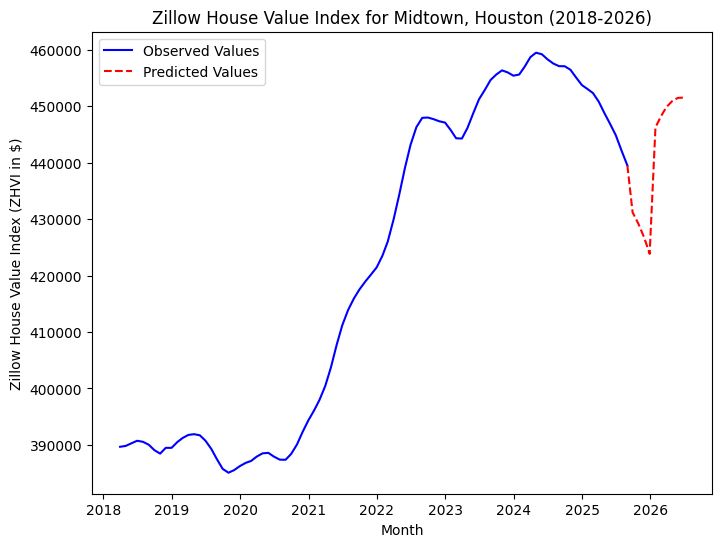

In [550]:
# create timeseries data for predictions to be paired with
future_months = future_predictors['month'].astype(str)
future_years = future_predictors['year'].astype(str)
future_time = pd.to_datetime(future_months + '/28/' + future_years, format = '%m/%d/%Y')

# add last real values to predicted values to connect lines
predictions = pd.concat([pd.Series(response[len(response) - 1]), predictions])
future_time = pd.concat([pd.Series(zhvi.loc[len(zhvi['month']) - 1, 'month']), future_time])

# plot real and predicted data

plt.figure(figsize = (8, 6))
plt.plot(zhvi['month'], response, color = 'blue', linestyle = '-', label = 'Observed Values')
plt.plot(future_time, predictions, color = 'red', linestyle = '--', label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Zillow House Value Index (ZHVI in $)')
plt.title('Zillow House Value Index for Midtown, Houston (2018-2026)')
plt.legend()
plt.show()

## Conclusion

Through trial and error, I was able to create a linear regression model that can predict the Zillow House Value Index, a proxy for median house value. This was done by considering time and number of houses listed on the market. In the graph of the observed values and predictions for the next 10 months, there is a continuation of the dip followed by a spike after the new year begins. This is because the year is heavily weighted in the model, despite the fact that years don't actually move in dijointed movements like that. Thes predictions can be interpretted as seeing a continuation of the current downward trend followed by a leveling out with the expectation that housing prices will continue to increase over the years.